# Data cleaning and EDA
Mains TODO:

Dealing with outlayers and empty values. 

Prepare the time series adecuate for training (2 summers for max pressure forecasting (region of interest because it is when free cooling is mainly not available) and 1 year at least for electrical consumption). 

Then we will try to forecast the next 24 hours (latest 48 data points). 

We will obtain RMSE and SMAPE (Pending BIC and AIC) for 12 hours forecast (24 data points), 24 hours (48 data points) and 7 days (168 latest data points)

5 Exogenous average Temperature time series (In, Out, Ambient, Evaporator, Ambient-Setpoint) in Bars

1 Exogenous cluster nodes total average Electric Consumption variable in W (will be converted to Kw)

1 Exogenous n working compressors time Series

2 Main Time Series - max Pressure in Bars and Chiller total average Power consumption in kW

All of them have a 30 min sliding window granularity

In [1]:
# imports and useful variables
import sys
import os
import numpy as np
import pandas as pd
import dask as dd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format
sns.set_style("whitegrid")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"
print(os.listdir(data_path + "/03_primary"))
print(os.listdir(data_path + "/04_feature"))
# First lets convert to KW
consumption_cluster = pd.read_parquet(
    data_path + "/03_primary/" + "consumption_total_average_30_min_W"
)
consumption_cluster.total_average_power_consumption_W = (
    consumption_cluster.total_average_power_consumption_W / 1000
)
consumption_cluster = consumption_cluster.rename(
    columns={"total_average_power_consumption_W": "total_average_power_consumption_kW"}
)

consumption_chillers = pd.read_parquet(
    data_path + "/03_primary/" + "chiller_1and2_consumption_total_average_30_min_kW"
)
max_pressure = pd.read_parquet(data_path + "/04_feature/" + "max_pressure_Bars")
n_compressors = pd.read_parquet(data_path + "/04_feature/" + "n_working_compressors")
temperature = pd.read_parquet(
    data_path + "/04_feature/" + "average_temperature_Degrees"
)
for i in [
    consumption_cluster,
    consumption_chillers,
    max_pressure,
    n_compressors,
    temperature,
]:
    # Spark steps regarding the time window (works with posix time) can lead to duplicate entries, lets ensure each dataframe does not contain duplicated rows
    i.drop_duplicates(inplace=True)
    i.time = pd.to_datetime(i.time)
    i["year"] = i.time.dt.year
    i["month"] = i.time.dt.month
    i["week"] = i.time.dt.week
# Preparing final dataframes with the deesired window time frames
consumption_train = consumption_cluster[["time"]].copy()
consumption_train = consumption_train[
    consumption_train.time >= pd.to_datetime("2018-06-21 00:00:00")
]
consumption_train = consumption_train[
    consumption_train.time < pd.to_datetime("2021-06-01 00:00:00")
]
pressure_train = consumption_cluster[["time"]].copy()
pressure_train = pressure_train[
    pressure_train.time >= pd.to_datetime("2018-06-21 00:00:00")
]
pressure_train = pressure_train[
    pressure_train.time < pd.to_datetime("2020-09-23 00:00:00")
]
pressure_train = pressure_train[
    (pressure_train.time < pd.to_datetime("2018-09-23 00:00:00"))
    | (
        (pressure_train.time >= pd.to_datetime("2019-06-21 00:00:00"))
        & (pressure_train.time < pd.to_datetime("2019-09-23 00:00:00"))
    )
    | (pressure_train.time >= pd.to_datetime("2020-06-21 00:00:00"))
]
consumption_cluster.set_index("time", inplace=True, drop=False)


['active_chiller', 'consumption_total_average_30_min_W', 'chiller_1and2_consumption_total_average_30_min_kW', 'chiller_1and2_compressor_1and2_pressure_max_30min_P', 'chiller_1and2_temperatureAll_average_30min_P']
['max_pressure_Bars', 'n_working_compressors', 'average_temperature_Degrees']


# Consumption cluster cleaning and study

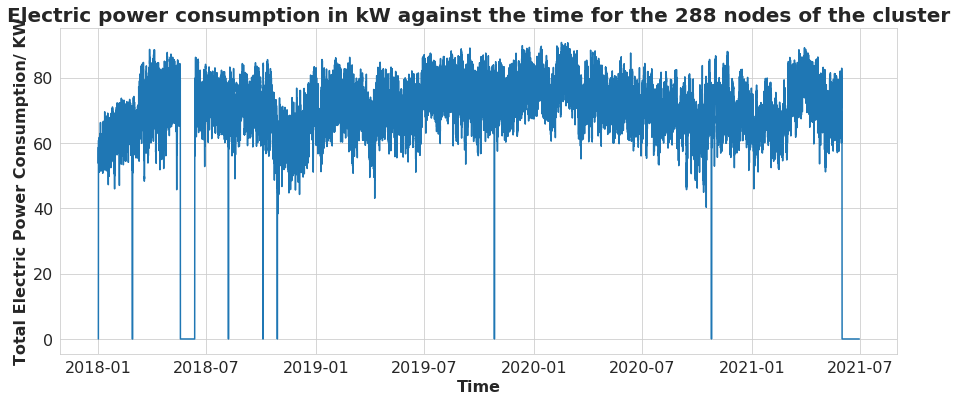

In [2]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_cluster["time"],
    consumption_cluster["total_average_power_consumption_kW"],
)

ax.set_title(
    "Electric power consumption in kW against the time for the 288 nodes of the cluster",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Total Electric Power Consumption/ KW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/c6601_daily_last2years_ts.svg", format="svg",dpi =600)
plt.show()
plt.close()


As discussed, and because of both seeting Nan to 0 in Pyspark plus ffill from the Grafana Dashboard and Hive Data Lake owners. However, as discussed with Javier, it should not be 0 consumption, only when restarting the cluster, which is not sigfnificative. Lets substitute by interpolation on those few outlayers.

In [3]:
consumption_cluster.total_average_power_consumption_kW[
    consumption_cluster.total_average_power_consumption_kW < 42
] = np.nan
consumption_cluster.total_average_power_consumption_kW = (
    consumption_cluster.total_average_power_consumption_kW.interpolate(method="time")
)
# consumption_cluster.total_average_power_consumption_kW = (
#     consumption_cluster.total_average_power_consumption_kW.interpolate()
# )
consumption_cluster.total_average_power_consumption_kW.fillna(
    consumption_cluster.total_average_power_consumption_kW.mean(), inplace=True
)  # Just for the first value
consumption_cluster = consumption_cluster.copy()


/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


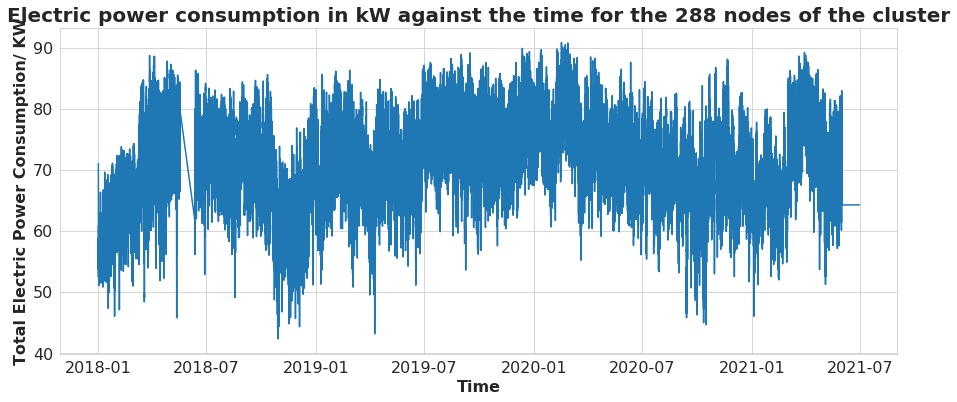

In [4]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_cluster["time"],
    consumption_cluster["total_average_power_consumption_kW"],
)

ax.set_title(
    "Electric power consumption in kW against the time for the 288 nodes of the cluster",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Total Electric Power Consumption/ KW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/c6601_daily_last2years_ts.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [5]:
#Tomamos un año entero para trabajar con el consumo y dos veranos para la presion
consumption_cluster.reset_index(drop = True, inplace=True)
consumption_train = pd.merge(consumption_train, consumption_cluster, on = "time")
pressure_train = pd.merge(pressure_train, consumption_cluster, on = "time")

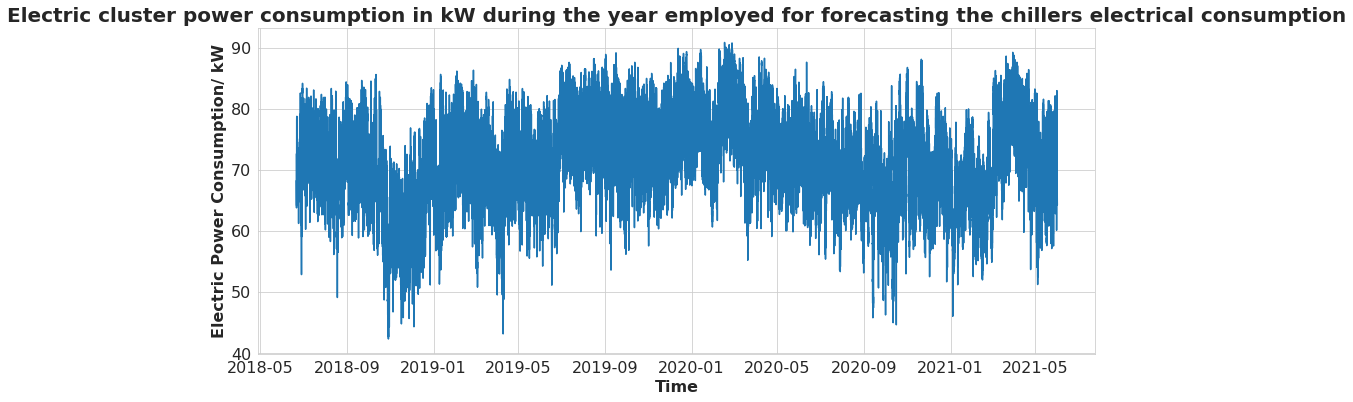

In [6]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"], consumption_train["total_average_power_consumption_kW"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Electric cluster power consumption in kW during the year employed for forecasting the chillers electrical consumption",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Electric Power Consumption/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/cluster_consumption_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


Maybe too granular to visualize, lets visualize the region to predict:

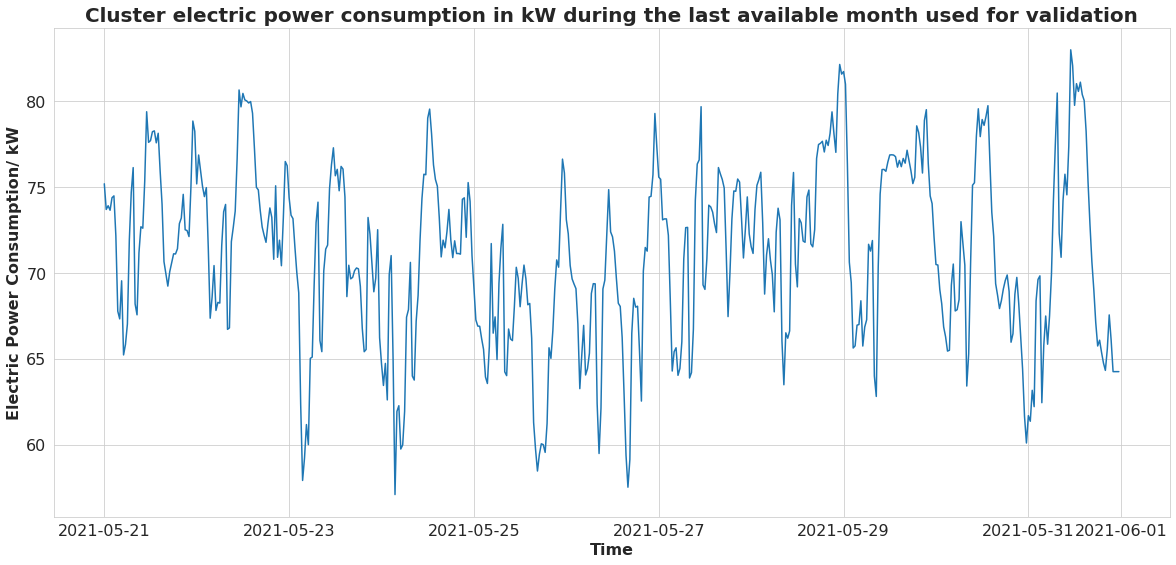

In [7]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
consumption_train_Validation = consumption_train[consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")].copy()
fig, ax = plt.subplots(figsize=(20, 9))
sns.lineplot(
    consumption_train_Validation["time"], consumption_train_Validation["total_average_power_consumption_kW"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Cluster electric power consumption in kW during the last available month used for validation",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Electric Power Consumption/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/cluster_consumption_ValidationMonth.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [8]:
# variable = 'total_average_power_consumption_kW'
# fig, ax = plt.subplots(figsize=(15, 6))

# palette = sns.color_palette("ch:2.5,-.2,dark=.3", 4)
# sns.lineplot(pressure_train['time'], pressure_train[variable], hue=pressure_train['month'], palette=palette)
# ax.set_title('Seasonal plot of the cluster power consumption for summer of 2019 and 2020', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
# ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
# ax.set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))


# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# sns.boxplot(pressure_train['year'], pressure_train[variable], ax=ax[0])
# ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
# ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
# ax[0].set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))

# sns.boxplot(pressure_train['month'], pressure_train[variable], ax=ax[1])
# ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
# ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
# ax[1].set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))

# Pressure plots

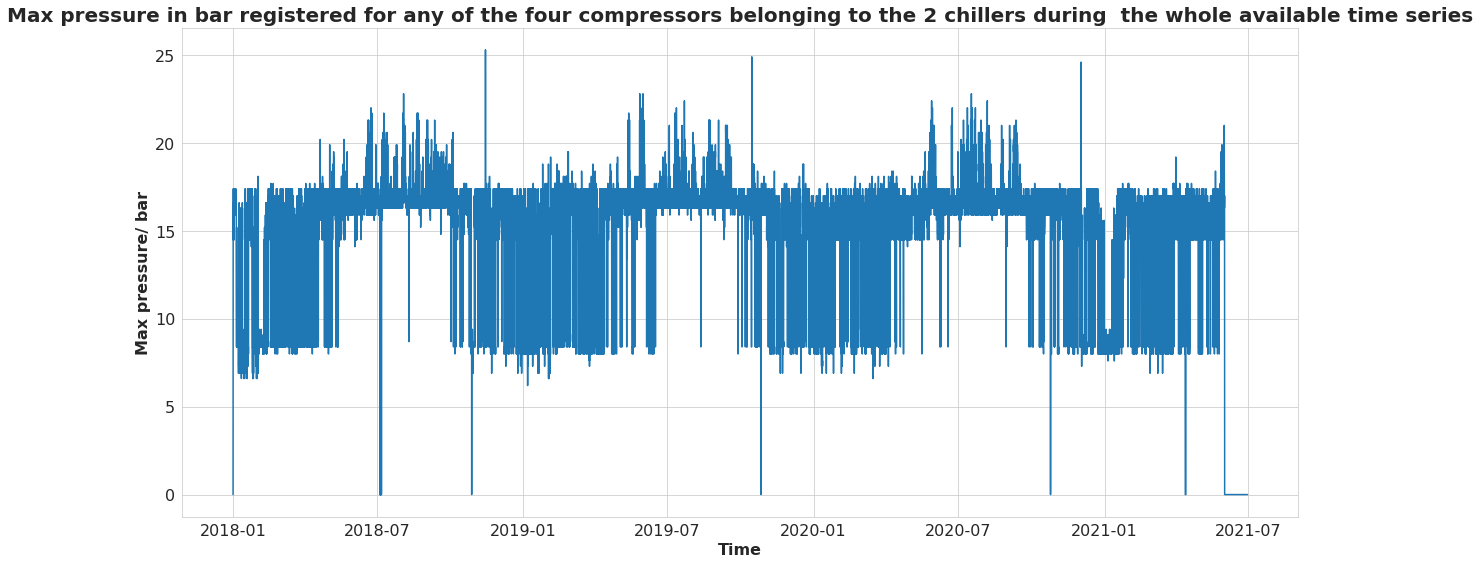

In [9]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
#consumption_train_Validation = consumption_train[consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")].copy()
fig, ax = plt.subplots(figsize=(20, 9))
sns.lineplot(
    max_pressure["time"], max_pressure["max_pressure_Bars"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the whole available time series",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/cluster_consumption_ValidationMonth.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [10]:
max_pressure.set_index("time", inplace=True, drop=False)
max_pressure.max_pressure_Bars[
    (max_pressure.max_pressure_Bars <5) | (max_pressure.max_pressure_Bars>24)
] = np.nan
max_pressure.max_pressure_Bars = (
    max_pressure.max_pressure_Bars.interpolate(method="time")
)
max_pressure.max_pressure_Bars.fillna(
    max_pressure.max_pressure_Bars.mean(), inplace=True
)  # Just for the first value
max_pressure.max_pressure_Bars = max_pressure.max_pressure_Bars.copy()
max_pressure.reset_index(drop = True, inplace=True)

#Tomamos un año entero para trabajar con el consumo y dos veranos para la presion
consumption_train = pd.merge(consumption_train, max_pressure[["time", "max_pressure_Bars"]], on = "time")
pressure_train = pd.merge(pressure_train, max_pressure[["time", "max_pressure_Bars"]], on = "time")

/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


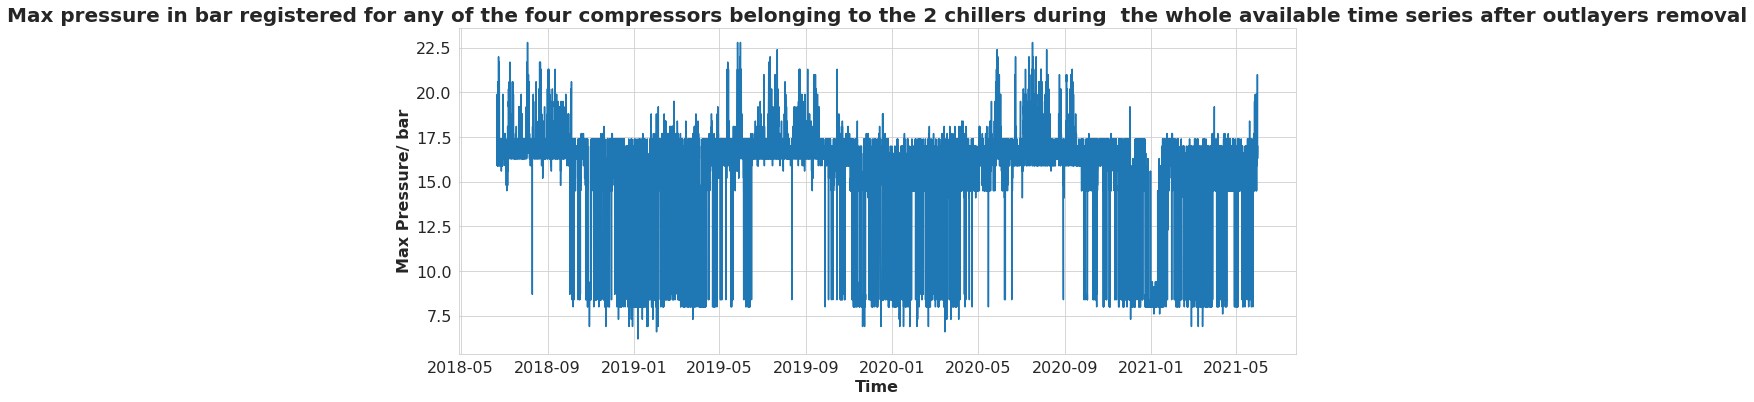

In [11]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"], consumption_train["max_pressure_Bars"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the whole available time series after outlayers removal",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max Pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/ma_pressure_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


Notese que en las regiones temporales que se corresponden con verano son aquellas en las que no se registran apenas valores cercanos a los 7.5 bares. Esto es porque es en verano cuando menos se puede aprovechar el free cooling y las enfriadoras mas trabajan. Por ese mismo motivo, a la hora de predecir presion maxima no nos estamos fijando mas que en los veranos, mientras que cuando la usamos como serie exogena para el consumo empleamos ambos

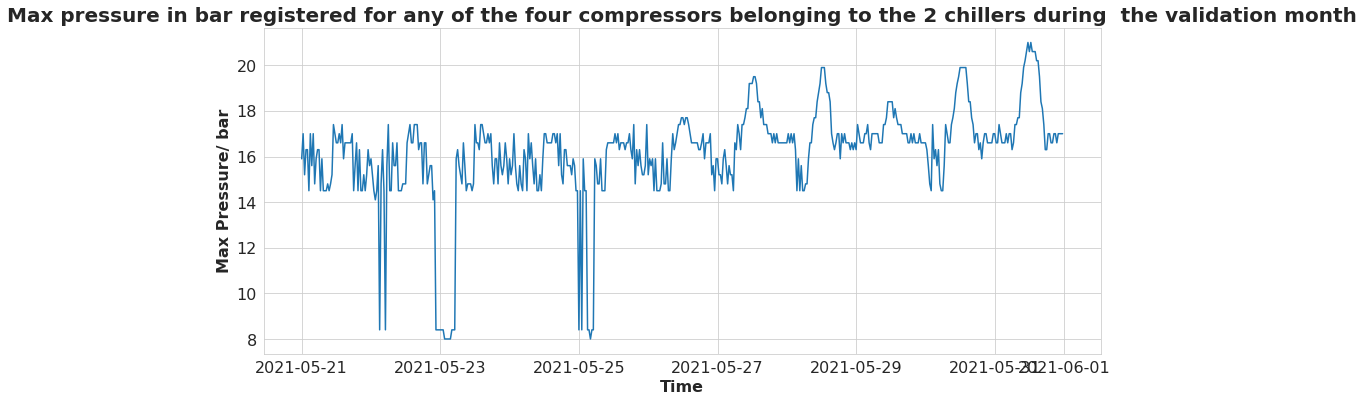

In [12]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["max_pressure_Bars"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the validation month",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max Pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/ma_pressure_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


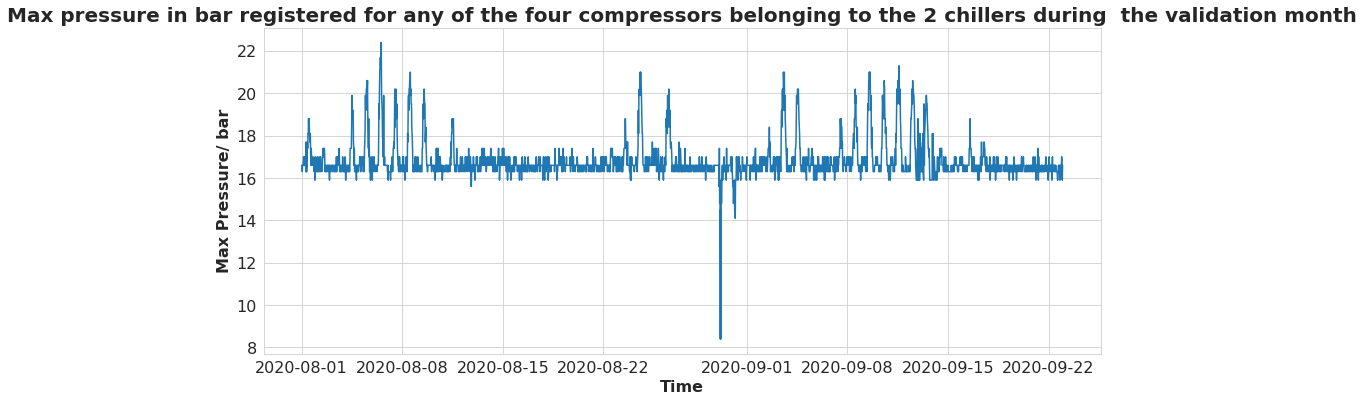

In [13]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    pressure_train["time"][pressure_train.time >= pd.to_datetime("2020-08-01 00:00:00")], pressure_train["max_pressure_Bars"][pressure_train.time >= pd.to_datetime("2020-08-01 00:00:00")], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the validation month",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max Pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/ma_pressure_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [14]:
pressure_train

,time,total_average_power_consumption_kW,year,month,week,max_pressure_Bars
0,2018-06-21 00:00:00,72.61,2018,6,25,16.30
1,2018-06-21 00:30:00,72.07,2018,6,25,16.60
2,2018-06-21 01:00:00,71.22,2018,6,25,16.60
3,2018-06-21 01:30:00,70.63,2018,6,25,16.60
4,2018-06-21 02:00:00,70.70,2018,6,25,16.30
...,...,...,...,...,...,...
13531,2020-09-22 21:30:00,70.75,2020,9,39,16.60
13532,2020-09-22 22:00:00,70.52,2020,9,39,17.00
13533,2020-09-22 22:30:00,70.42,2020,9,39,16.30
13534,2020-09-22 23:00:00,69.94,2020,9,39,15.90


Mirando un verano (no Free Cooling en principio)

# Chiller consumption

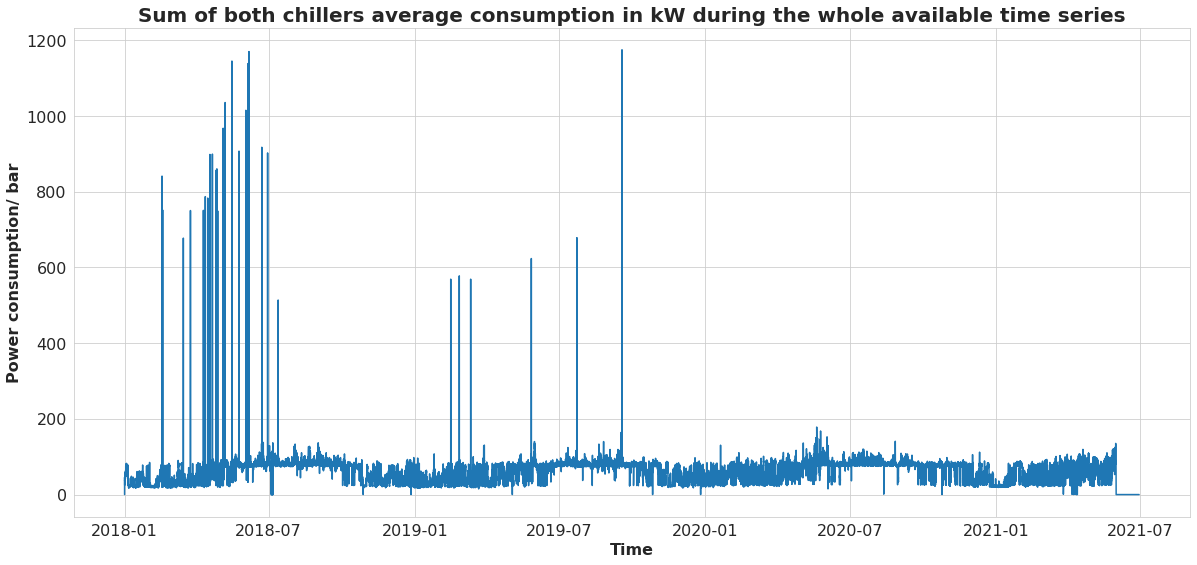

In [15]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
#consumption_train_Validation = consumption_train[consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")].copy()
fig, ax = plt.subplots(figsize=(20, 9))
sns.lineplot(
    consumption_chillers["time"], consumption_chillers["total_average_power_consumption_kW"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Sum of both chillers average consumption in kW during the whole available time series",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Power consumption/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/cluster_consumption_ValidationMonth.svg", format="svg",dpi =600)
plt.show()
plt.close()

In [16]:
consumption_chillers.set_index("time", inplace=True, drop=False)
consumption_chillers.total_average_power_consumption_kW[
    (consumption_chillers.total_average_power_consumption_kW >200) | (consumption_chillers.total_average_power_consumption_kW<5)
] = np.nan
consumption_chillers.total_average_power_consumption_kW = (
    consumption_chillers.total_average_power_consumption_kW.interpolate(method="time")
)
consumption_chillers.total_average_power_consumption_kW.fillna(
    consumption_chillers.total_average_power_consumption_kW.mean(), inplace=True
)  # Just for the first value
consumption_chillers.reset_index(drop = True, inplace=True)

consumption_train = pd.merge(consumption_train, consumption_chillers[["time", "total_average_power_consumption_kW"]], on = "time", suffixes=("_nodes", "_chillers"))
pressure_train = pd.merge(pressure_train, consumption_chillers[["time", "total_average_power_consumption_kW"]], on = "time", suffixes=("_nodes", "_chillers"))

/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Outlayers discussion with Javier: given both machines specs, any data point over 200 kW is a measurement error. It should not show values such as 1-2 kW since the pump consumption takes already 10 kW

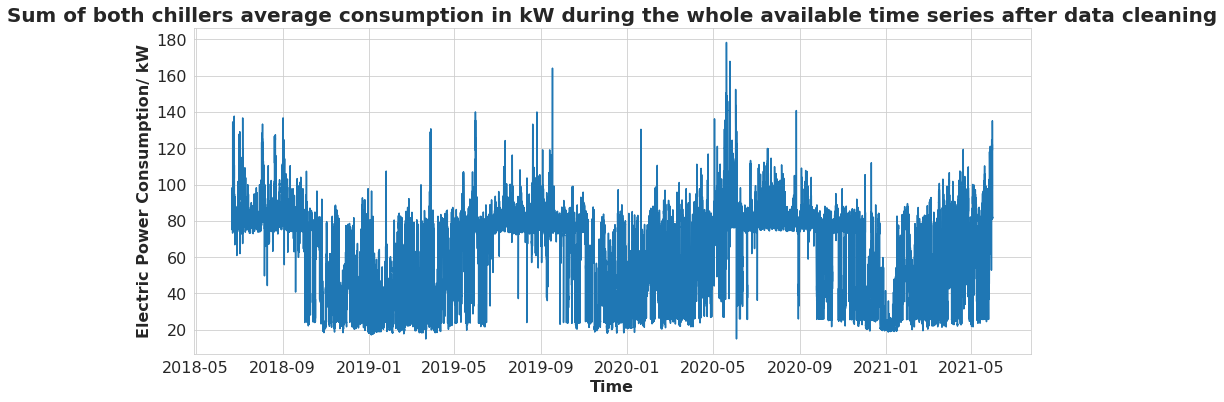

In [18]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Sum of both chillers average consumption in kW during the whole available time series after data cleaning",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Electric Power Consumption/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


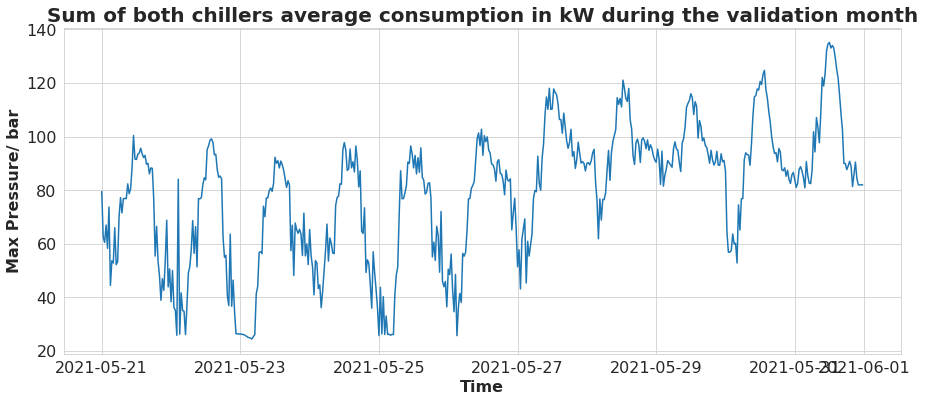

In [19]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
)

ax.set_title(
    "Sum of both chillers average consumption in kW during the validation month",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max Pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_validation.svg", format="svg",dpi =600)
plt.show()
plt.close()


n_compressors does not need a exhaustive data cleaning

In [25]:
consumption_train = pd.merge(consumption_train, n_compressors[["time", "n_working_compressors"]], on = "time", )
pressure_train = pd.merge(pressure_train, n_compressors[["time", "n_working_compressors"]], on = "time", )

In [26]:
#Propr to n_compressors and temperature lets save 
consumption_train.to_parquet(data_path+"/05_model_input/"+"consumption_train")
pressure_train.to_parquet(data_path+"/05_model_input/"+"pressure_train")

# Temperature TS features

Primero tienes bateria de refrigeracion que es parecida a la de un coche, es por la que pasa el agua por el cpd, es la climatizadora como tal. Este agua fria proveniente de nuestra refrigeradora en la iteraccion previa del ciclo de refrigeracion absorbe el calor del aire caliente del CPD y se calienta a 18-25 grados, que es como llega en el flujo de caudal a la enfriadora.

Cadas enfriadora tiene una bomba que hace fluir el agua (y te hace el consumo minimo mencionado) mas una de repuesto por msi no funciona. Si no funciolna la bomba el agua se estanca o se cierra la compuerta y solo pasa a circular por la otra. El t In es el que sale de la climatizadora y llega a esta maquina.
El T evap es la temperatura despues de pasar por el segundo elemento de nuestra enfruiadora, que es el evaporador. Funciona de modo similar al condensador de uina nevera. Circula por una bateria. 
Si la T evap es menor que t In es que se ha enfriado el agua sin necesirtar de usar los compresores, que son los que enfrian activamente el agua en caso de que el free cooling sea insuficiente.

De modo que T in y T ambiente deben ser las mismas en ambas enfriadoras
T out y T evap pueden ser distintas en caso de que una funcione y otra no.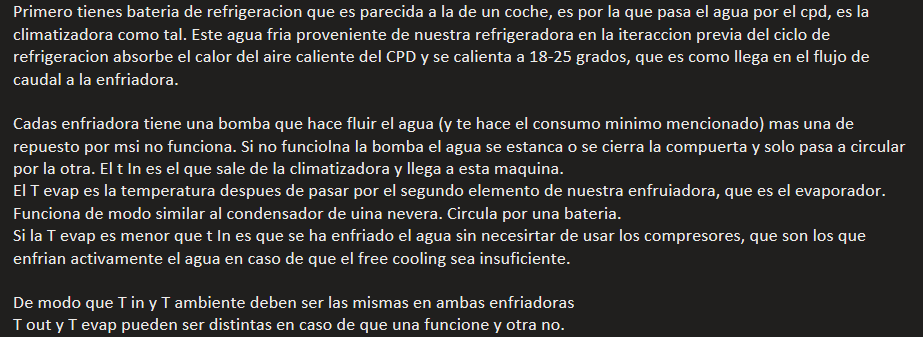

In [28]:
temperature.head()

,time,Temperature_Ambient_Degrees,Temperature_Evaporator_Degrees,Temperature_In_Degrees,Temperature_Out_Degrees,Temperature_Ambient_Minus_Setpoint_Degrees,year,month,week
0,2017-12-31 23:00:00,0.00,0.00,0.00,0.00,-14.53,2017,12,52
1,2017-12-31 23:30:00,10.08,15.62,16.71,15.26,-4.46,2017,12,52
2,2018-01-01 00:00:00,10.04,15.68,17.00,15.90,-4.49,2018,1,1
3,2018-01-01 00:30:00,10.21,15.66,16.76,15.37,-4.32,2018,1,1
4,2018-01-01 01:00:00,10.58,15.61,16.70,15.49,-3.95,2018,1,1


/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


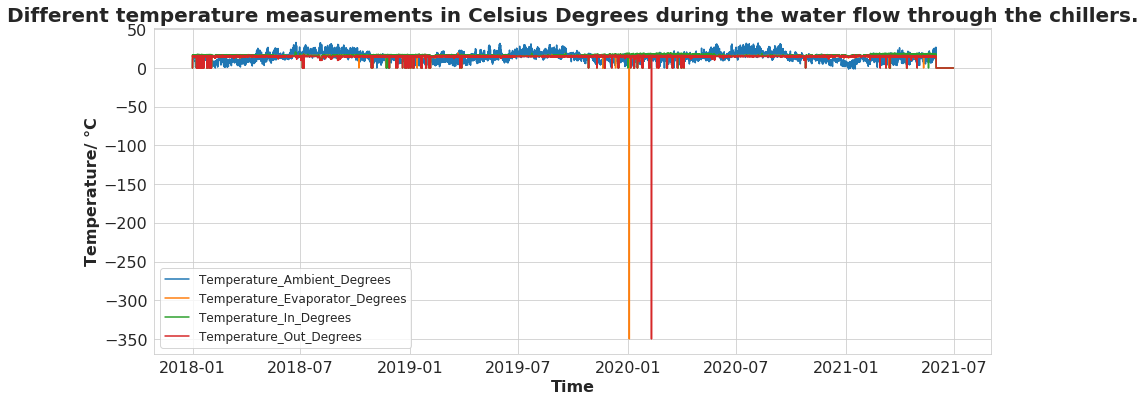

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot multiple lines with legend
sns.lineplot(x=temperature["time"], y=temperature["Temperature_Ambient_Degrees"], label="Temperature_Ambient_Degrees")
sns.lineplot(x=temperature["time"], y=temperature["Temperature_Evaporator_Degrees"], label="Temperature_Evaporator_Degrees")
sns.lineplot(x=temperature["time"], y=temperature["Temperature_In_Degrees"], label="Temperature_In_Degrees")
sns.lineplot(x=temperature["time"], y=temperature["Temperature_Out_Degrees"], label="Temperature_Out_Degrees")

ax.set_title("Different temperature measurements in Celsius Degrees during the water flow through the chillers.",
             fontsize=20, loc="center", fontdict=dict(weight="bold"))
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel("Temperature/ °C", fontsize=16, fontdict=dict(weight="bold"))
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)

# Show the legend
plt.legend(fontsize=12)

plt.show()
plt.close()



In [32]:
temperature.set_index("time", inplace=True, drop=False)
temperature.Temperature_Evaporator_Degrees[
    (temperature.Temperature_Evaporator_Degrees < -10)
] = np.nan
temperature.Temperature_Out_Degrees[
    (temperature.Temperature_Out_Degrees < -10)
] = np.nan
temperature.Temperature_Evaporator_Degrees = (
    temperature.Temperature_Evaporator_Degrees.interpolate(method="time")
)
temperature.Temperature_Out_Degrees = temperature.Temperature_Out_Degrees.interpolate(
    method="time"
)

temperature.Temperature_Evaporator_Degrees.fillna(
    temperature.Temperature_Evaporator_Degrees.mean(), inplace=True
)  # Just for the first value
temperature.Temperature_Out_Degrees.fillna(
    temperature.Temperature_Out_Degrees.mean(), inplace=True
)  # Just for the first value
temperature.reset_index(drop=True, inplace=True)
consumption_train = pd.merge(
    consumption_train,
    temperature[
        [
            "time",
            "Temperature_In_Degrees",
            "Temperature_Out_Degrees",
            "Temperature_Ambient_Degrees",
            "Temperature_Evaporator_Degrees",
        ]
    ],
    on="time",
)
pressure_train = pd.merge(
    pressure_train,
    temperature[
        [
            "time",
            "Temperature_In_Degrees",
            "Temperature_Out_Degrees",
            "Temperature_Ambient_Degrees",
            "Temperature_Evaporator_Degrees",
        ]
    ],
    on="time",
)

/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


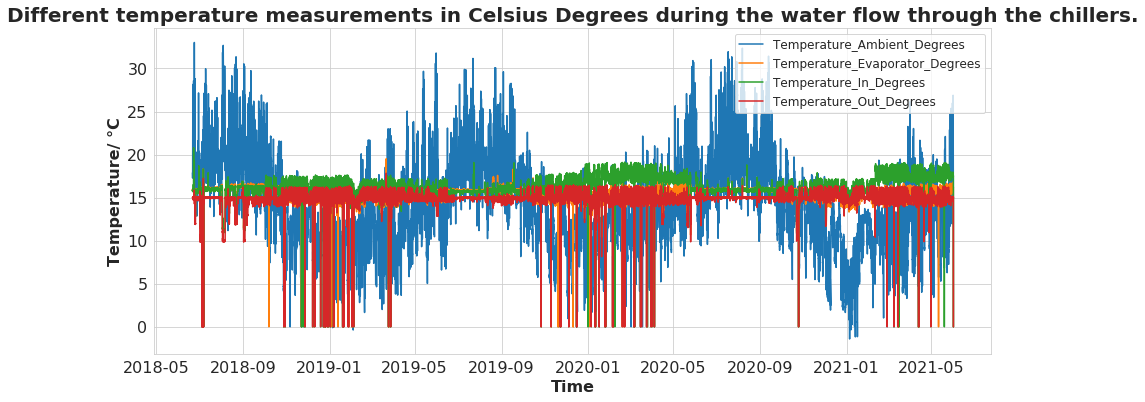

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot multiple lines with legend
sns.lineplot(x=consumption_train["time"], y=consumption_train["Temperature_Ambient_Degrees"], label="Temperature_Ambient_Degrees")
sns.lineplot(x=consumption_train["time"], y=consumption_train["Temperature_Evaporator_Degrees"], label="Temperature_Evaporator_Degrees")
sns.lineplot(x=consumption_train["time"], y=consumption_train["Temperature_In_Degrees"], label="Temperature_In_Degrees")
sns.lineplot(x=consumption_train["time"], y=consumption_train["Temperature_Out_Degrees"], label="Temperature_Out_Degrees")

ax.set_title("Different temperature measurements in Celsius Degrees during the water flow through the chillers.",
             fontsize=20, loc="center", fontdict=dict(weight="bold"))
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel("Temperature/ °C", fontsize=16, fontdict=dict(weight="bold"))
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)

# Show the legend
plt.legend(fontsize=12)

plt.show()
plt.close()




In [36]:
#Propr to n_compressors and temperature lets save 
consumption_train.to_parquet(data_path+"/05_model_input/"+"consumption_train")
pressure_train.to_parquet(data_path+"/05_model_input/"+"pressure_train")